## OpenAQ Sentinel5 mapper

This notebook is intended as a demonstration as to how we could use openaq data to validate Sentinel5P measurements of air quality and vice-versa. Sentinel5P data were used extensively during the coronavirus lockdowns across the world for showing acute [differences in air quality owing to reduced industrial/economic activity](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-5P/Coronavirus_lockdown_leading_to_drop_in_pollution_across_Europe).

![](https://www.esa.int/var/esa/storage/images/esa_multimedia/images/2020/03/nitrogen_dioxide_concentrations_over_france/21899732-1-eng-GB/Nitrogen_dioxide_concentrations_over_France_article.jpg)

The objective of this project is to investigate whether a reasonable mapping exists between Sentinel5P full column estimates of atmospheric gases and the related concentration of these measured on the ground by air quality stations. The incentive is that the two could then be used in tandem, for extrapolating beyond the coverage of the sensors within openaq's network, and for quality validation of measurements within the network. 


### The functions 

For this notebook, I've deployed the appropriate lambda functions in this repository, hosted on my own AWS account. The endpoint will:

1. Search the openaq network for sensors/readings within a given radius of the coordinate - will return a message if none are found
2. Average the values at each station for each day (can average over all sensors with a query param 'agg_sensors=1' if looking for simpler use)
3. Retrieve the Sentinel5P daily estimates at these coordinates
4. Merge the two datasets and return the data

### Retrieve some data

First we intiliaze some constants and set our query parameters

In [1]:
%matplotlib inline

import requests
import pandas as pd
import matplotlib.pyplot as plt

# The lambda endpoint
URL_STEM = 'https://x8qgzno5cd.execute-api.eu-central-1.amazonaws.com/'

# This parameter is proxied to openaq
# the number of metres around our coordinates we'll look for sensors
radius = 5000

# Max per page, we'll just use this here
limit = 10000

# Parameter setting, oneof 'co', 'no2', 'o3', 'so2'
parameter = 'no2'

We can use nominatim for geocoding - it'll allow us to transform a city name into a coordinate set we can use with the API

In [2]:
# Nominatim can geocode a city name for us to get coordinates
# OpenAQ's API allows to search by city, but it's simpler
# to use coordinates here
SEARCH_URL = 'https://nominatim.openstreetmap.org/search/' \
             '?city=%s&format=json'

# Hometown :)
my_city = 'Dublin'
city_resp = requests.get(SEARCH_URL%my_city)

# Just take the first value from the response
lat, lon = city_resp.json()[0]['lat'], city_resp.json()[0]['lon']

Put our parameters together and make the request to our lambda endpoint

In [3]:
params = {'lat': lat, 'lon': lon, 'radius': radius, 'limit': limit,
          'parameter': parameter}
data_for_city = requests.get(URL_STEM, params=params)

Our response outputs by default a dictionary mapping {sensor_name: [readings]}. I'll do on openapi doc for this eventually, but for now that's all we need to know!

In [4]:
results = data_for_city.json()

Here I've introduced a couple of methods for plotting time series/scattercharts of the resulting data.

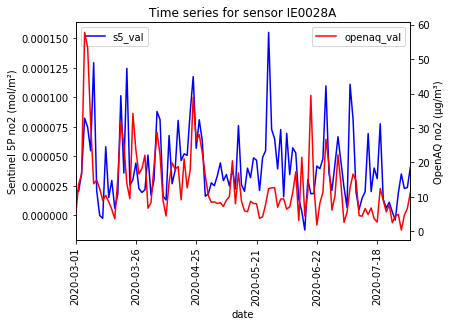

<Figure size 576x576 with 0 Axes>

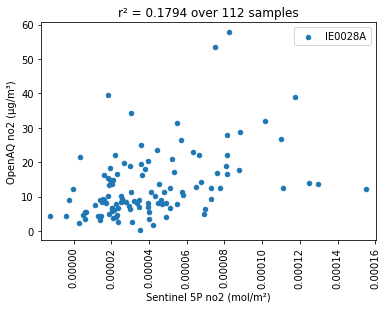

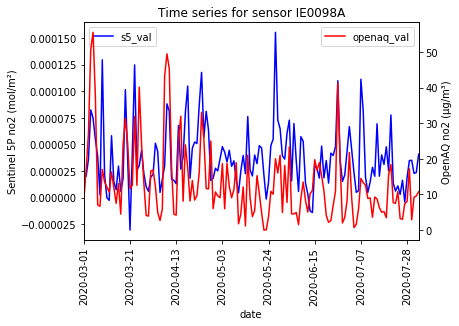

<Figure size 576x576 with 0 Axes>

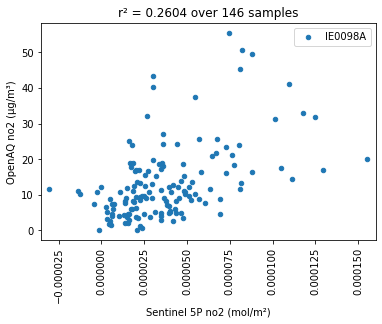

In [5]:
def plot_scatter(df, meta, sensor):
    p = plt.figure(figsize=(8,8))
    ax = df.plot(x='s5_val', y='openaq_val', kind='scatter', 
            xlim=(df['s5_val'].min() - 5e-6, 
                  df['s5_val'].max() + 5e-6), label=sensor)
    plt.xticks(rotation=90)
    plt.title(f"r\u00b2 = {pd.np.corrcoef(df['openaq_val'], df['s5_val'])[0][1] ** 2:0.4f} over {len(df)} samples")
    plt.xlabel(f'Sentinel 5P {meta["parameter"]} ({meta["s5_unit"]})')
    plt.ylabel(f'OpenAQ {meta["parameter"]} ({meta["openaq_unit"]})')


def plot_time_series_comparison(df, meta, sensor):
    fig = plt.figure()
    ax = plt.gca()
    ax = df.plot(x='date', y='s5_val', ax=ax, c='b', rot=90, legend=False)

    ax2 = ax.twinx()
    ax2 = df.plot(x='date', y='openaq_val', ax=ax2, c='r', legend=False)
    ax.legend(loc=2)
    ax2.legend(loc=0)

    ax.set_ylabel(f'Sentinel 5P {meta["parameter"]} ({meta["s5_unit"]})')
    ax2.set_ylabel(f'OpenAQ {meta["parameter"]} ({meta["openaq_unit"]})')
    plt.title(f'Time series for sensor {sensor}')
                   
                   
def plot_results(results):
    data = results['results']
    meta = results['meta']
    for sensor in data.keys():
        df = pd.DataFrame(data[sensor])
        plot_time_series_comparison(df, meta, sensor)
        plot_scatter(df, meta, sensor)

plot_results(results)

In [6]:
# We can wrap up the query for a city into a method
def get_results_for_city(city, parameter='no2'):
    city_resp = requests.get(SEARCH_URL%city)
    lat, lon = city_resp.json()[0]['lat'], city_resp.json()[0]['lon']
    print(f'Encoded {city} to coordinates {lat},{lon}')
    params = {'lat': lat, 'lon': lon, 'radius': radius, 
              'limit': limit, 'parameter': parameter}
    resp_for_city = requests.get(URL_STEM, params=params)
    results = resp_for_city.json()
    if 'results' in results.keys():
        plot_results(results)
    else:
        return results

Can change the parameter to see how correlations vary

Encoded Dublin to coordinates 53.3497645,-6.2602732


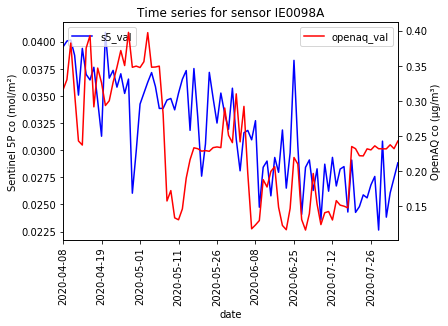

<Figure size 576x576 with 0 Axes>

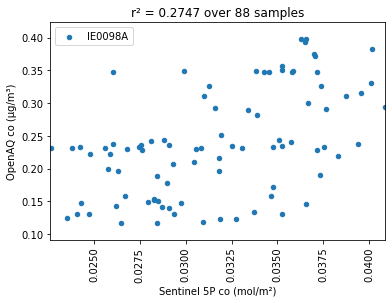

In [7]:
get_results_for_city('Dublin', parameter='co')

Or change the city to see if we can spot correlations...

get_results_for_city('San Francisco')

In [ ]:
get_results_for_city('San Francisco')

Encoded San Francisco to coordinates 37.7790262,-122.4199061
